In [17]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

2025-07-30 17:51:28.172249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 17:51:28.507435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753887088.630136    1043 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753887088.665209    1043 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753887088.945541    1043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [ ]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='rgb', # если использовать предобученную ч/б модель, то изменить этот параметр на 'grayscale'
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='lanczos5', # Попробовать: bicubic (лучшая, но тяжёлая) lanczos3/5 (вроде норм), было nearest
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [ ]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1753887094.324754    1043 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [ ]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [ ]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1067 изображений
Класс PNEUMONIA (1): 3141 изображений


2025-07-30 17:51:40.922431: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [ ]:
#применим аугментацию
def augment_and_preprocess_train(image, label):
    image_augmented = data_augmentation_pipeline(image, training=True)

    image_float_0_1 = tf.image.convert_image_dtype(image_augmented, tf.float32)
    brightness_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    image_brightened = image_float_0_1 * brightness_factor
    image_brightened = tf.clip_by_value(image_brightened, 0.0, 1.0)

    image_for_resnet_preprocess = image_brightened * 255.0
    image_preprocessed = preprocess_input(image_for_resnet_preprocess) 

    return image_preprocessed, label

def preprocess_val_test(image, label):
    image = tf.cast(image, tf.float32) # Просто переводим в float32
    image_preprocessed = preprocess_input(image) # И применяем ту же предобработку ResNet
    return image_preprocessed, label


df_train_processed = df_train.map(augment_and_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1077 изображений
Класс PNEUMONIA (1): 3131 изображений


2025-07-30 17:51:50.205225: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

In [ ]:
# создадим модель
tf.keras.backend.set_image_data_format('channels_last')
backbone = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
backbone.trainable = False

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())         
model.add(Dropout(0.1))   
model.add(Dense(128, activation='relu'))                
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
history_head = model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=5
)

Epoch 1/5


I0000 00:00:1753887124.790448    2081 service.cc:152] XLA service 0x7a1fdc001f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753887124.790483    2081 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-07-30 17:52:05.428668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753887127.102586    2081 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-30 17:52:08.293361: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5396', 204 bytes spill stores, 204 bytes spill loads

2025-07-30 17:52:08.320099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  2/132 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5938 - auc: 0.5253 - loss: 0.8395 - precision: 0.7822 - recall: 0.6729  

I0000 00:00:1753887134.293762    2081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/132 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8125 - auc: 0.8733 - loss: 0.4648 - precision: 0.9294 - recall: 0.8108

2025-07-30 17:52:24.388629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5396', 4 bytes spill stores, 4 bytes spill loads

2025-07-30 17:52:24.438764: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5396', 116 bytes spill stores, 116 bytes spill loads

2025-07-30 17:52:24.376348: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5396', 1000 bytes spill stores, 1000 bytes spill loads

2025-07-30 17:52:24.603447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5396', 3960 bytes spill stores, 3940 bytes spill loads



132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - accuracy: 0.8126 - auc: 0.8735 - loss: 0.4644 - precision: 0.9295 - recall: 0.8108 - val_accuracy: 0.6064 - val_auc: 0.4747 - val_loss: 0.7873 - val_precision: 0.7229 - val_recall: 0.7433
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8390 - auc: 0.9010 - loss: 0.3997 - precision: 0.9443 - recall: 0.8324 - val_accuracy: 0.7090 - val_auc: 0.4900 - val_loss: 0.7754 - val_precision: 0.7322 - val_recall: 0.9536
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.8324 - auc: 0.9079 - loss: 0.3970 - precision: 0.9469 - recall: 0.8153 - val_accuracy: 0.7178 - val_auc: 0.5596 - val_loss: 0.7439 - val_precision: 0.7301 - val_recall: 0.9718
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8292 - auc: 0.9041 - loss: 0.4048 - precision: 0.9434 - recall: 0.8178 - val_accuracy: 0.7119 - val_auc: 0.5186 - val_loss: 0.7960 - val_precision: 0.7250 - val_recall: 0.9732
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━

In [ ]:
backbone.trainable = True
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-5), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=10,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/10


2025-07-30 17:53:50.340496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16969', 12 bytes spill stores, 16 bytes spill loads



132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8181 - auc: 0.8713 - loss: 0.4656 - precision: 0.9269 - recall: 0.8205

132/132 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.8181 - auc: 0.8714 - loss: 0.4654 - precision: 0.9270 - recall: 0.8205 - val_accuracy: 0.7256 - val_auc: 0.2605 - val_loss: 1.1536 - val_precision: 0.7270 - val_recall: 0.9973 - learning_rate: 1.0000e-05
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.8476 - auc: 0.9059 - loss: 0.3862 - precision: 0.9450 - recall: 0.8451 - val_accuracy: 0.7256 - val_auc: 0.3681 - val_loss: 1.2504 - val_precision: 0.7260 - val_recall: 0.9987 - learning_rate: 1.0000e-05
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8258 - auc: 0.9004 - loss: 0.4062 - precision: 0.9347 - recall: 0.8190

132/132 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.8258 - auc: 0.9005 - loss: 0.4061 - precision: 0.9347 - recall: 0.8190 - val_accuracy: 0.7158 - val_auc: 0.5082 - val_loss: 0.8158 - val_precision: 0.7317 - val_recall: 0.9639 - learning_rate: 1.0000e-05
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8418 - auc: 0.9109 - loss: 0.3794 - precision: 0.9436 - recall: 0.8367

132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - accuracy: 0.8418 - auc: 0.9109 - loss: 0.3794 - precision: 0.9436 - recall: 0.8367 - val_accuracy: 0.6084 - val_auc: 0.6521 - val_loss: 0.7360 - val_precision: 0.8139 - val_recall: 0.5987 - learning_rate: 1.0000e-05
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.8473 - auc: 0.9105 - loss: 0.3774 - precision: 0.9468 - recall: 0.8423 - val_accuracy: 0.4121 - val_auc: 0.7051 - val_loss: 1.0899 - val_precision: 0.9207 - val_recall: 0.2041 - learning_rate: 1.0000e-05
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8458 - auc: 0.9162 - loss: 0.3634 - precision: 0.9530 - recall: 0.8344
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 251ms/step - accuracy: 0.8458 - auc: 0.9162 - loss: 0.3634 - precision: 0.9530 - recall: 0.8344 - val_accuracy: 0.3975 - val_auc: 0.6438 - val_loss: 1.1566 - val_precision: 0.9032 - val_recall: 0.1887 - learning_rate

In [ ]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5550 - auc: 0.4002 - loss: 0.8027 - precision: 0.3410 - recall: 0.4118
Test Loss: 0.784909188747406
Test Accuracy: 0.5705128312110901


___
    ДО class_weights:
    Test Loss: 0.6504877805709839
    Test Accuracy: 0.6089743375778198

    ПОСЛЕ class_weights:
    Test Loss: 0.6858784556388855
    Test Accuracy: 0.6330128312110901
___

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step


2025-07-30 17:59:10.952016: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


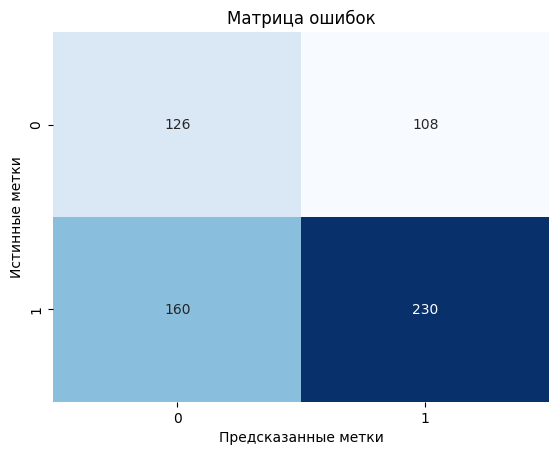

              precision    recall  f1-score   support

      NORMAL       0.44      0.54      0.48       234
   PNEUMONIA       0.68      0.59      0.63       390

    accuracy                           0.57       624
   macro avg       0.56      0.56      0.56       624
weighted avg       0.59      0.57      0.58       624



In [ ]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

___
  ДО class_weights:
  0 - 17 - 217
  1 - 27 - 363
    | 0  |  1 |

  ПОСЛЕ class_weights:
  0 - 11 - 223
  1 - 6 - 384
    | 0  |  1 |
___